In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:\
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
np.random.seed(42)

Machine Learning Project Checklist 

1. Look at the big picture and frame the problem
2. Get the data
3. Explore the data to gain insights
4. Prepare the data for Machine Learning algorithms
5. Select and Train Model
6. Fine-tune your model


# 1. Frame the problem

The task is to find out who survived the disaster given a set of details about a passenger on the titanic. An output of 1, if they had survived and 0, if they had not. This is a supervised problem and a classifcation task. Model and batch learning techniques are to be implemented.

## Performance Measure

Will be using a utility function of precision and recall, via a confusion matrix. 

# 2. Getting the Data

In [3]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv', index_col=0)
test_data = pd.read_csv('/kaggle/input/titanic/test.csv',index_col=0)

## Quick look at the Data Structure

In [4]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Can see there are a total of 11 attributes: `Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked`.

In [5]:
train_data.info() # quick description of the data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Very small amount of data will be implementing cross validation during validation of models.
Let's have a closer look at text attributes.

In [6]:
text_attributes = [col for col in train_data.columns if train_data[col].dtype=='object']
text_attributes

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

Two categorical attributes which are `Embarked` and `Sex`. It seems that cabin is missing a lot values. Might drop the attribute all together. 

In [7]:
train_data["Ticket"].value_counts()

1601          7
CA. 2343      7
347082        7
3101295       6
CA 2144       6
             ..
C.A. 29178    1
A/4. 34244    1
370371        1
349244        1
F.C. 12750    1
Name: Ticket, Length: 681, dtype: int64

There may seem to be a pattern there where some tickets are just numbers while others also include letters at the start. Now to have a look at the numerical attributes.

In [8]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Only `Age` is missing some values.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

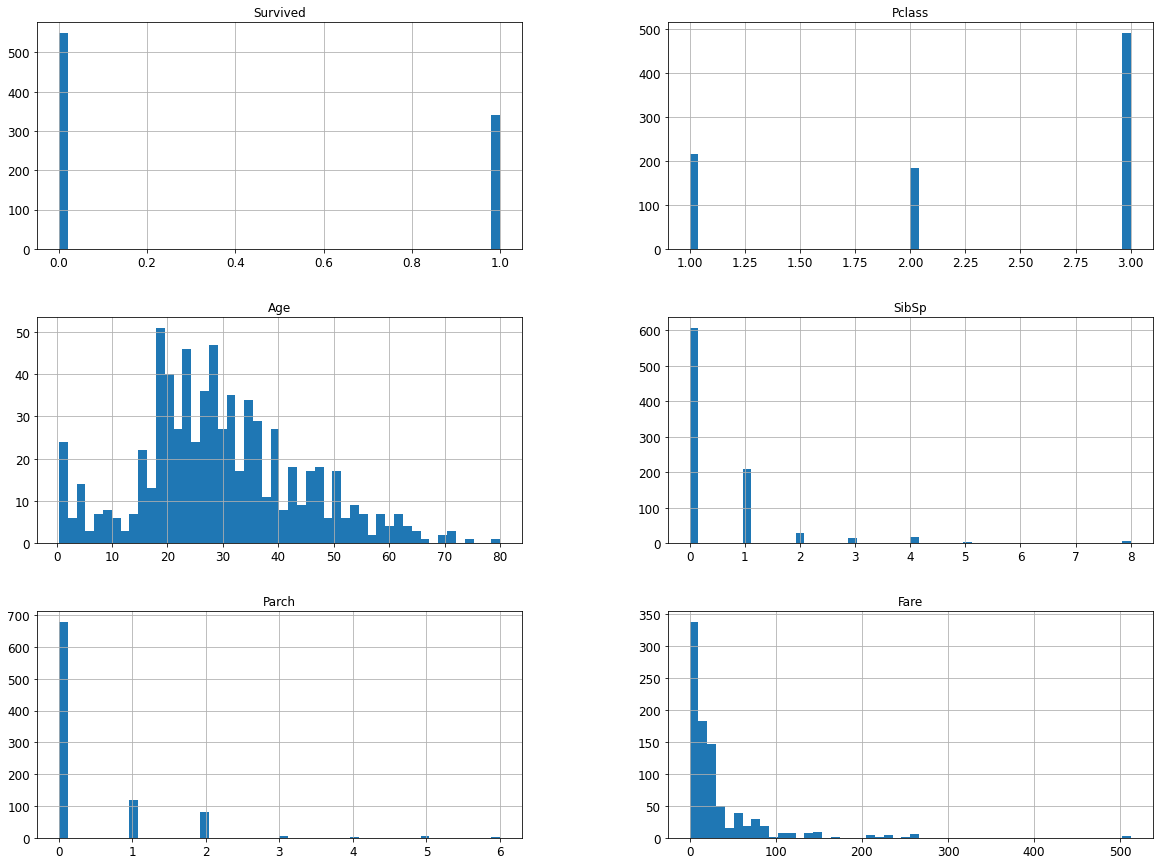

In [9]:
train_data.hist(bins=50, figsize=(20,15))

Got a few tail-heavy distributions namely, `SibSp, Fare, Parch, Age`. Theres seems to be a high number of passengers with 0 cost for their fares.

# Discover and Visualize Data to Give Insights

In [10]:
titanic = train_data.copy()

## Looking for Correlations

In [11]:
corr_matrix = titanic.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

In [12]:
women = titanic.loc[titanic.Sex=='female']["Survived"]
women_rate = sum(women)/len(women)
print("% of women who survived:",women_rate)

% of women who survived: 0.7420382165605095


In [13]:
men = titanic.loc[titanic.Sex=='male']["Survived"]
men_rate = sum(men)/len(men)
print("% of men who survived:",men_rate)

% of men who survived: 0.18890814558058924


It seems that you were more like to survive if you were a women.

In [14]:
titanic = train_data.drop(["Survived","Cabin","Name","Ticket"],axis=1).dropna(subset=["Embarked"])
titanic_labels = train_data.dropna(subset=["Embarked"])["Survived"].copy()

In [15]:
median_age = titanic["Age"].median()
titanic["Age"].fillna(median_age, inplace=True)

In [16]:
titanic.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,3,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,3,male,35.0,0,0,8.0500,S


In [17]:
test_data.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [18]:
from sklearn.impute import SimpleImputer

In [19]:
imputer = SimpleImputer(strategy="median")
titanic_num = titanic.drop(["Sex","Embarked"],axis=1)
imputer.fit(titanic_num)

SimpleImputer(strategy='median')

In [20]:
imputer.statistics_

array([ 3.    , 28.    ,  0.    ,  0.    , 14.4542])

In [21]:
titanic_num.median().values

array([ 3.    , 28.    ,  0.    ,  0.    , 14.4542])

In [22]:
X = imputer.transform(titanic_num)
titanic_tr = pd.DataFrame(X,columns=titanic_num.columns,index=titanic_num.index)

In [23]:
num_or_arbit_txt = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
titanic_txt_attr = titanic.drop(num_or_arbit_txt,axis=1)

In [24]:
titanic_txt_attr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 1 to 891
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sex       889 non-null    object
 1   Embarked  889 non-null    object
dtypes: object(2)
memory usage: 20.8+ KB


In [25]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
titanic_txt_encoded = ordinal_encoder.fit_transform(titanic_txt_attr)
titanic_txt_encoded[:10]

array([[1., 2.],
       [0., 0.],
       [0., 2.],
       [0., 2.],
       [1., 2.],
       [1., 1.],
       [1., 2.],
       [1., 2.],
       [0., 2.],
       [0., 0.]])

In [26]:
ordinal_encoder.categories_

[array(['female', 'male'], dtype=object), array(['C', 'Q', 'S'], dtype=object)]

In [27]:
from sklearn.preprocessing import OneHotEncoder
txt_encoder = OneHotEncoder()
titanic_txt_1hot = txt_encoder.fit_transform(titanic_txt_attr)
titanic_txt_1hot

<889x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1778 stored elements in Compressed Sparse Row format>

In [28]:
titanic_txt_1hot.toarray()

array([[0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0.]])

In [29]:
txt_encoder.categories_

[array(['female', 'male'], dtype=object), array(['C', 'Q', 'S'], dtype=object)]

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [31]:
num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('std_scaler',StandardScaler()),
])

In [32]:
from sklearn.compose import ColumnTransformer

num_attribs = list(titanic_num)
cat_attribs = list(titanic_txt_attr)
full_pipeline = ColumnTransformer([
    ("num",num_pipeline, num_attribs),
    ("cat",OneHotEncoder(),cat_attribs)
])

titanic_prepared = full_pipeline.fit_transform(titanic)

In [33]:
titanic_prepared

array([[ 0.82520863, -0.56367407,  0.43135024, ...,  0.        ,
         0.        ,  1.        ],
       [-1.57221121,  0.66921696,  0.43135024, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82520863, -0.25545131, -0.47519908, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.82520863, -0.10133993,  0.43135024, ...,  0.        ,
         0.        ,  1.        ],
       [-1.57221121, -0.25545131, -0.47519908, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82520863,  0.20688282, -0.47519908, ...,  0.        ,
         1.        ,  0.        ]])

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
lin_reg = LinearRegression()
lin_reg.fit(titanic_prepared,titanic_labels)

LinearRegression()

In [36]:
some_data = titanic.iloc[:5]
some_labels = titanic_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [0.09140338 0.92906182 0.61404703 0.87716119 0.05716751]
Labels: [0, 1, 1, 1, 0]


In [37]:
some_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,3,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,3,male,35.0,0,0,8.0500,S


In [38]:
rounded = []
for item in lin_reg.predict(some_data_prepared):
    rounded.append(round(item))
rounded

[0, 1, 1, 1, 0]

In [39]:
from sklearn.metrics import mean_squared_error

In [40]:
titanic_pred1 = lin_reg.predict(titanic_prepared)

In [41]:
def rounder(x):
    return round(x)

In [42]:
def array_rounded(x):
    return np.array([rounder(xi) for xi in x])

In [43]:
titanic_final_pred = array_rounded(titanic_pred1)

In [44]:
titanic_final_pred

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,

In [45]:
titanic_label

NameError: name 'titanic_label' is not defined

In [46]:
lin_mse = mean_squared_error(titanic_labels, titanic_final_pred)
lin_rmse = np.sqrt(lin_mse)

In [47]:
lin_rmse

0.44997187763644414

In [48]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(titanic_prepared,titanic_labels)

DecisionTreeRegressor()

In [49]:
titanic_predictions = tree_reg.predict(titanic_prepared)
tree_mse = mean_squared_error(titanic_labels,titanic_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.109237737936925

In [50]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, titanic_prepared, titanic_labels,
                        scoring='neg_mean_squared_error', cv=5)
tree_rmse_scores = np.sqrt(-scores)

In [51]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation", scores.std())

In [52]:
display_scores(tree_rmse_scores)

Scores: [0.49173005 0.47514494 0.4268164  0.49018912 0.46495179]
Mean: 0.46976646045730225
Standard deviation 0.023648685415871437


In [53]:
lin_scores = cross_val_score(lin_reg, titanic_prepared,titanic_label,
                   scoring="neg_mean_squared_error",cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

NameError: name 'titanic_label' is not defined

In [54]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(titanic_prepared,titanic_labels)

RandomForestRegressor()

In [55]:
titanic_predictions = tree_reg.predict(titanic_prepared)
tree_mse = mean_squared_error(titanic_labels, titanic_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.109237737936925

In [56]:
test = test_data.drop(["Cabin","Name","Ticket"],axis=1).dropna(subset=["Embarked"])
test_prepared = full_pipeline.fit_transform(test)
predictions = tree_reg.predict(titanic_prepared)

In [57]:
from sklearn.linear_model import SGDClassifier

In [58]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(titanic_prepared,titanic_labels)

SGDClassifier(random_state=42)

In [59]:
cross_val_score(sgd_clf,titanic_prepared,titanic_labels, cv=10,scoring="accuracy")

array([0.68539326, 0.70786517, 0.79775281, 0.73033708, 0.78651685,
       0.7752809 , 0.7752809 , 0.80898876, 0.7752809 , 0.79545455])

In [60]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(titanic_prepared, titanic_labels)

LogisticRegression(random_state=42)

In [61]:
cross_val_score(log_reg,titanic_prepared,titanic_labels, cv=10,scoring="accuracy")

array([0.79775281, 0.79775281, 0.75280899, 0.80898876, 0.78651685,
       0.76404494, 0.78651685, 0.78651685, 0.80898876, 0.82954545])

In [62]:
predictions = log_reg.predict(test_prepared)

In [63]:
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [64]:
len(p)

NameError: name 'p' is not defined

In [65]:
output = pd.DataFrame({'PassengerId': test_data.index, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [66]:
test_data.index

Int64Index([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,
            ...
            1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309],
           dtype='int64', name='PassengerId', length=418)

In [67]:
test_data.index

Int64Index([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,
            ...
            1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309],
           dtype='int64', name='PassengerId', length=418)